# 11-Advanced-Data-Storage-and-Retrieval/HOMEWORK

In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
from datetime import datetime, timedelta

## Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.sql import label

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Design a query to retrieve the last 12 months of precipitation data and plot the results. Calculate the date 1 year ago from today. Perform a query to retrieve the data and precipitation scores. Save the query results as a Pandas DataFrame and set the index to the date column. Sort the dataframe by date. Use Pandas Plotting with Matplotlib to plot the data. Rotate the xticks for the dates

<IPython.core.display.Javascript object>


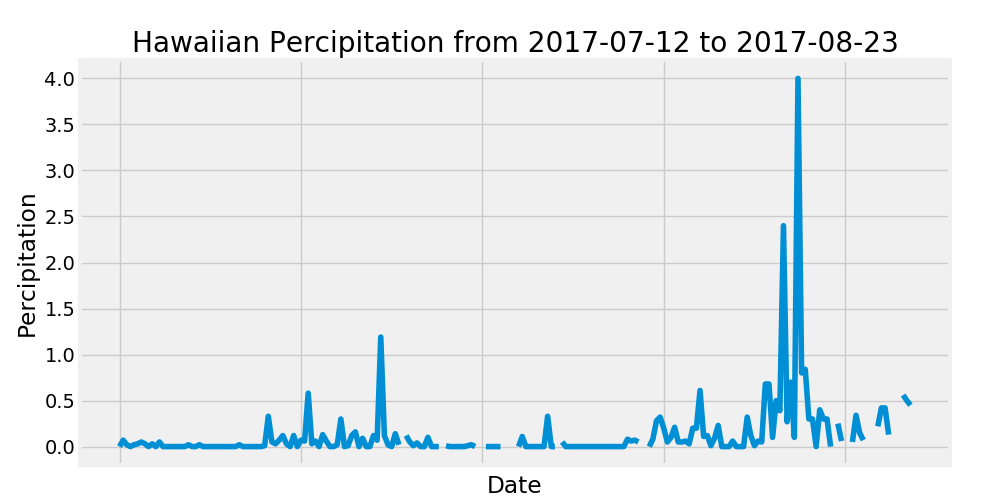

In [14]:
# calculate the date
current_time = datetime.now()
months_ago_12 = current_time - timedelta(days=365)

last_12 = session.query(measurement.date, measurement.prcp)\
        .filter(measurement.date > months_ago_12)
    
# construct data frame
last_12_rain = pd.read_sql_query(last_12.statement, engine, index_col = 'date')
last_12_rain.head()

# plot fig
last_12_rain.plot(figsize = (10, 5), rot = 45, legend = False, use_index = True)
plt.ylabel('Percipitation')
plt.xlabel('Date')
plt.title('Hawaiian Percipitation from %s to %s' % (last_12_rain.index.min(), last_12_rain.index.max()))
plt.show()

### Use Pandas to calcualte the summary statistics for the precipitation data

In [15]:
last_12_rain.describe()

prcp
count  202.000000
mean     0.129406
std      0.365464
min      0.000000
25%      0.000000
50%      0.020000
75%      0.117500
max      4.000000

### How many stations are available in this dataset?

In [16]:
stations = session.query(station.station)\
        .group_by(station.station).count()

stations

9

### What are the most active stations? List the stations and the counts in descending order.

In [17]:
act_stations = session.query(measurement.station, func.count(measurement.tobs))\
            .filter(station.station == measurement.station).group_by(measurement.station)\
            .order_by(func.count(measurement.tobs).desc()).all()

act_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

### Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature most active station.

In [18]:
high_act_station = session.query(measurement.station, func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs))\
        .filter(station.station == measurement.station)\
        .group_by(measurement.station)\
        .order_by(func.count(measurement.tobs).desc()).first()

high_act_station


('USC00519281', 54.0, 85.0, 71.66378066378067)

### Choose the station with the highest number of temperature observations. Query the last 12 months of temperature observation data for this station and plot the results as a histogram.

<IPython.core.display.Javascript object>


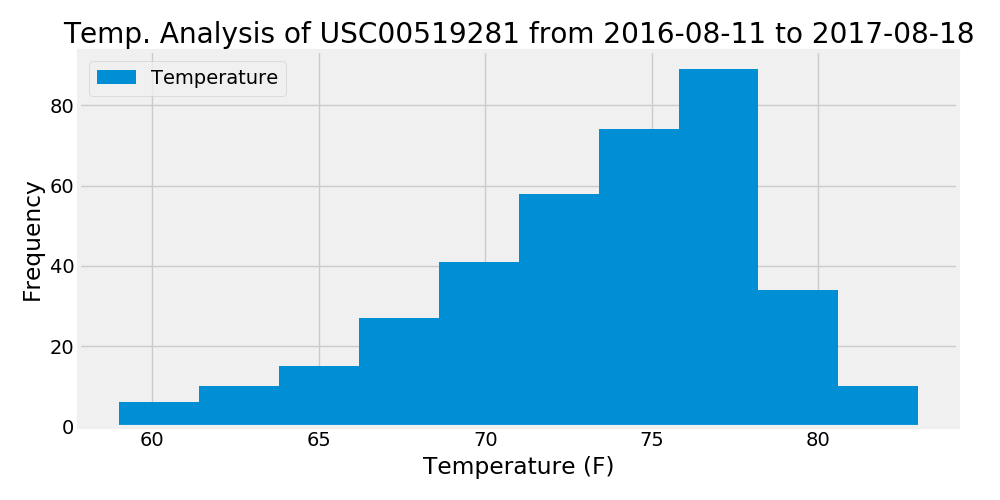

In [19]:
# calculate past 12 months and query
current_time = datetime.now()
past_year = current_time - timedelta(weeks=100)

high_tobs_st = session.query(measurement.date, measurement.tobs).\
                        filter(measurement.station == 'USC00519281').\
                        filter(measurement.date > past_year)

# dataframe 
hi_tobs_st_df = pd.read_sql_query(high_tobs_st.statement, engine, index_col = 'date')
hi_tobs_st_df.head()

# histogram
hi_tobs_st_df.plot(kind="hist",linewidth=4,figsize=(10,5))

plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title('Temp. Analysis of USC00519281 from %s to %s' % (hi_tobs_st_df.index.min(), hi_tobs_st_df.index.max()))
plt.legend(["Temperature"])
plt.tight_layout()

plt.show()

### Write a function called calc_temps that will accept start date and end date in the format '%Y-%m-%d'  and return the minimum, average, and maximum temperatures for that range of dates

In [20]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TAVE, and TMAX"""
    start = start_date - timedelta(days=365)
    end = end_date - timedelta(days=365)
    
    temp_values = session.query(label('max_temp',func.max(measurement.tobs)),\
                    label('min_temp',func.min(measurement.tobs)),\
                    label('avg_temp',func.avg(measurement.tobs))).\
                    filter(measurement.date >= start).\
                    filter(measurement.date <= end)
    
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
                    filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()
    
calc_temps(datetime(2012,5,20), datetime(2012,5,25))

[(68.0, 73.84210526315789, 78.0)]

### Use your previous function calc_temps to calculate the tmin, tavg, and tmax for your trip using the previous years data for those same dates.

In [21]:
calc_temps(datetime(2017,5,20), datetime(2017,5,25))

[(69.0, 74.93103448275862, 87.0)]

### Plot the results from your previous query as a bar chart. Use "Trip Avg Temp" as your Title. Use the average temperature for the y value. Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

<IPython.core.display.Javascript object>


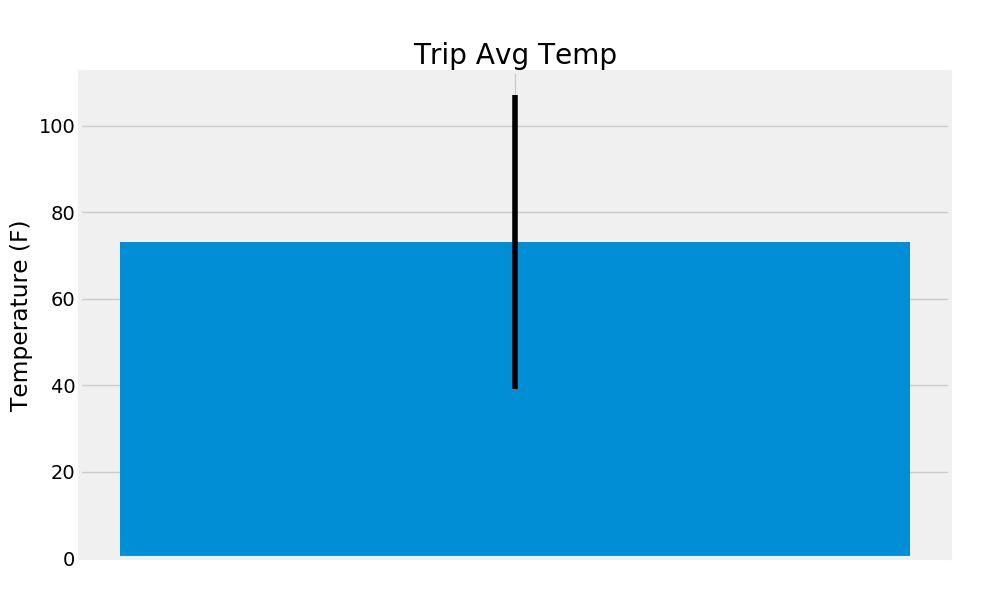

[(69.0, 74.93103448275862, 87.0)]

In [28]:
def calc_temps(start_date, end_date):
    start = start_date - timedelta(days=365)
    end = end_date - timedelta(days=365)
    
    temp_values = session.query(label('max_temp',func.max(measurement.tobs)),\
                    label('min_temp',func.min(measurement.tobs)),\
                    label('avg_temp',func.avg(measurement.tobs))).\
                    filter(measurement.date >= start).\
                    filter(measurement.date <= end)
    
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
                    filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()
    
temp_values = session.query(label('max_temp',func.max(measurement.tobs)),\
                    label('min_temp',func.min(measurement.tobs)),\
                    label('avg_temp',func.avg(measurement.tobs)))

avg_temp = temp_values[0].avg_temp
max_temp = temp_values[0].max_temp
min_temp = temp_values[0].min_temp

plt.figure(figsize=(10,6))
plt.bar(1, avg_temp, yerr= (max_temp - min_temp), tick_label = "")
plt.ylabel("Temperature (F)")
plt.title("Trip Avg Temp")
plt.tight_layout
plt.show()


calc_temps(datetime(2017,5,20), datetime(2017,5,25))

### Calculate the rainfall per weather station for your trip dates using the previous year's matching dates. Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

In [23]:
def rain_calc(start_date,end_date):
    start = start_date - timedelta(days=365)
    end = end_date - timedelta(days=365)
    
    rain_station = session.query(station.name, station.station, label('average rainfall', func.avg(measurement.prcp))).\
                    filter(measurement.station == station.station).\
                    filter(measurement.date >= start).\
                    filter(measurement.date <= end).\
                    group_by(station.name,station.station).\
                    order_by(func.avg(measurement.prcp).desc())
    
    rain_station_df = pd.DataFrame(query_to_dict(rain_station))
       
    return rain_station_df


def query_to_dict(res):
    res_dict = []
    for rec in res:
        res_dict.append(rec)
        
    return res_dict

rain_calc(datetime(2016,5,20), datetime(2016,5,25))



name      station  average rainfall
0  KUALOA RANCH HEADQUARTERS 886.9, HI US  USC00514830             0.300
1      WAIMANALO EXPERIMENTAL FARM, HI US  USC00519523             0.264
2                     WAIHEE 837.5, HI US  USC00519281             0.184
3                    KANEOHE 838.1, HI US  USC00513117             0.178
4            MANOA LYON ARBO 785.2, HI US  USC00516128             0.046
5                    WAIKIKI 717.2, HI US  USC00519397             0.014
6       HONOLULU OBSERVATORY 702.2, HI US  USC00511918             0.000
7              UPPER WAHIAWA 874.3, HI US  USC00518838             0.000